Here We're Importing Necessary Packages. We used a mix of seaborn based plots as well as maplotlib. We also made sure to import the pipline package so we can streamline workflows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score)
import time
import os
os.makedirs("Outputs", exist_ok=True)

Next, we are doing a preprocessing step- making sure to seperate features and targets. Our response variable is binary ( 1= normal, 2= at-risk). We also deployed the Lable encoder form sklearn module so we can translate the binary variable ( 1 and 2) to represent 0 and 1- the way models use them.

In [ ]:
# Setting the random seed for reproducibility
np.random.seed(42)

#Loading the Data
# data = 'train_set.csv' # Vinith path
data = '../Data/train_set.csv' # Github path
df = pd.read_csv(data)

# Separate features and target
X_train = df.drop(columns=['fetal_health'])
y_train = df['fetal_health']

print("Training data shape:", X_train.shape)
print("Class distribution:\n", y_train.value_counts())

#Encoding the outcome variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
classes = label_encoder.classes_

print(f"\nEncoded classes: {classes}")
print(f"Encoded labels: {np.unique(y_train_encoded)}")

Training data shape: (1700, 11)
Class distribution:
 fetal_health
1.0    1322
2.0     378
Name: count, dtype: int64

Encoded classes: [1. 2.]
Encoded labels: [0 1]


Next, We defined our cross validation and scoring metrics. We used StratifiedKFold of 5 splits because we had class imbalance. We also made sure to set the seed at 42 so our code can be reproducible. We decided to look at accuracy, precision, recall and f1). Our final model eval will be comparing the f1 scores as well as the confusing matrix.

In [3]:
#Cross-Validation
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Let's Define the different scoring metrics for eval
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}


Here we our implementing the Gradient Boosting Model by creating a pipeline for precorssing and defing our hyperparmeter grid- testing our three configurations. We decided to experiment with learning rate, max_depth, and number of estimators ( similar to what we've been doing in our lab).

In [4]:
#Gradient Boosting Model
#Creating pipeline with preprocessing
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

#Defining hyperparameter grid
param_grid_boost = {
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 5, 7],
    'gb__n_estimators': [100, 200]   # added valid parameter
}

gb_start_time = time.time()

#Initializing GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid_boost,
    cv=cv_splitter,
    scoring='accuracy',
    n_jobs=-1,
)

grid_search_gb.fit(X_train, y_train_encoded)
gb_end_time = time.time()
print(f"Gradient Boosting fitting time: {(gb_end_time - gb_start_time)/60:.2f} minutes")

Gradient Boosting fitting time: 0.19 minutes


After that, in this code chunk, we are evaluating the graident boosting cross validation with multiple metrics. We also fitted our best parameter base dmodel using the training data and printed a classification report ( which has our metrics)- Confusion matrix and the F1 score.

  gb__learning_rate: 0.1
  gb__max_depth: 3
  gb__n_estimators: 200

Best cross-validation accuracy: 0.9453
Accuracy:  0.9453
Precision: 0.9449
Recall:    0.9453
F1-Score:  0.9444
Cross-Validation Confusion Matrix:
[[1290   32]
 [  61  317]]
              precision    recall  f1-score   support

         1.0       0.95      0.98      0.97      1322
         2.0       0.91      0.84      0.87       378

    accuracy                           0.95      1700
   macro avg       0.93      0.91      0.92      1700
weighted avg       0.94      0.95      0.94      1700



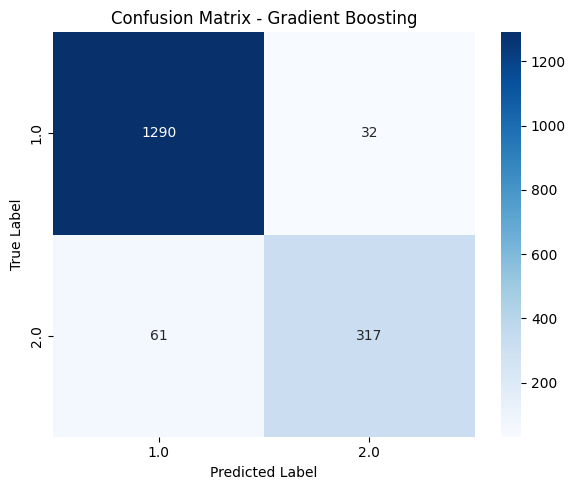

In [5]:
#Evaluation
for param, value in grid_search_gb.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation accuracy: {grid_search_gb.best_score_:.4f}")

#Evaluating with Multiple Metrics
best_gb_model = grid_search_gb.best_estimator_

gb_cv_results = cross_validate(best_gb_model, X_train, y_train_encoded,
                                cv=cv_splitter, scoring=scoring)

print(f"Accuracy:  {gb_cv_results['test_accuracy'].mean():.4f}" )
print(f"Precision: {gb_cv_results['test_precision_weighted'].mean():.4f}" )
print(f"Recall:    {gb_cv_results['test_recall_weighted'].mean():.4f}" )
print(f"F1-Score:  {gb_cv_results['test_f1_weighted'].mean():.4f}" )


from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(best_gb_model, X_train, y_train_encoded,
                               cv=cv_splitter)

gb_cm_cv = confusion_matrix(y_train_encoded, y_pred_cv)
print("Cross-Validation Confusion Matrix:")
print(gb_cm_cv)

print(classification_report(y_train_encoded, y_pred_cv,
                           target_names=[str(c) for c in classes]))

plt.figure(figsize=(6, 5))
sns.heatmap(gb_cm_cv, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Gradient Boosting')
plt.tight_layout()
plt.savefig("Outputs/gb_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

Finally, we also implemented feature importance to see which features had the most impact in our model. Printed out the top 10 features and their score impact


Top 10 Most Important Features:
                                               Feature  Importance
                       abnormal_short_term_variability    0.347211
                              prolongued_decelerations    0.150762
                  mean_value_of_short_term_variability    0.113247
percentage_of_time_with_abnormal_long_term_variability    0.085687
                                         accelerations    0.080208
                                        baseline_value    0.071924
                                  uterine_contractions    0.059436
                   mean_value_of_long_term_variability    0.057571
                                   light_decelerations    0.015100
                                        fetal_movement    0.012950


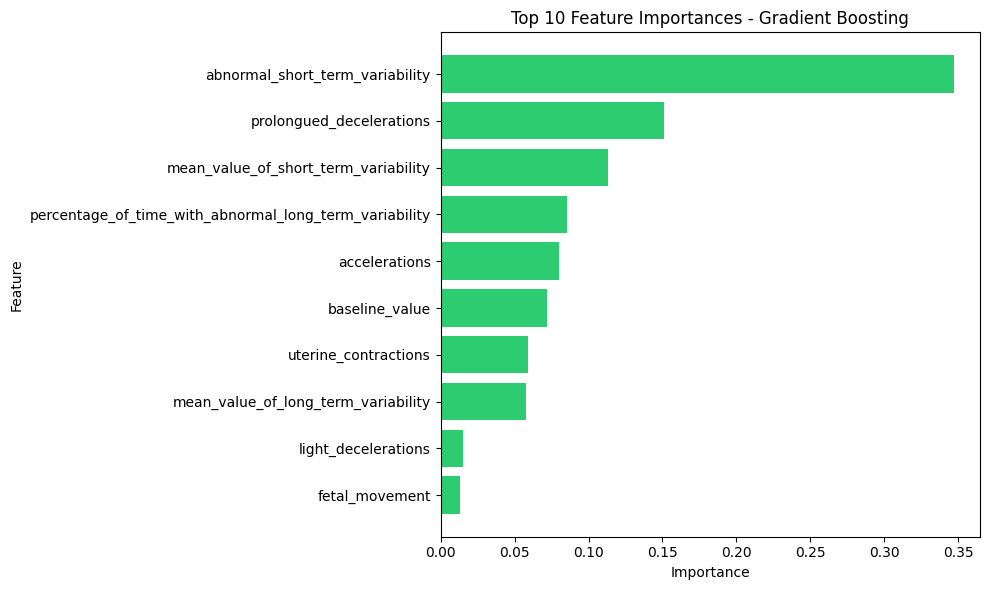

In [6]:

#Feature IMPORTANCE
features = X_train.columns
feature_importance_gb = best_gb_model.named_steps['gb'].feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance_gb
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10],
         feature_importance_df['Importance'][:10],
         color='#2ecc71')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Gradient Boosting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("Outputs/gb_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()